# Features creation

In this notebook, we create the features in order to train with machine learning models.

We need to find a good method to represent the text. As a first approach, we will work with TF-IDF Vectors (TF: Term Frequency - IDF: Inverse Document Frequency).

In [10]:
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
from scipy.sparse import csr_matrix

We load the data

In [2]:
path='/home/maggie/News_classifier/3.Data_Analysis_and_Visualizations/' 

with open(path + 'data.pickle', 'rb') as input_file:
    data = pickle.load(input_file)

In [3]:
data.shape

(26047, 17)

In [4]:
data.Label.value_counts()

Deportes                  5137
Política                  5080
Economía                  4573
Internacional             3649
Cultura y Espectáculos    3207
Sociedad                  2827
Policiales                1025
Ciencia y tecnología       549
Name: Label, dtype: int64

We will keep the labels Cultura y Espectáculos, Deportes, Economía, Internacional, Sociedad/Policiales and Política. We put together Sociedad and Policiales, because some newspapers put the crime articles in Sociedad and not in Policiales. We also do not keep the label Ciencia y Tecnología, because we do not have many articles to train.

In [5]:
data=data.replace({'Label':{'Policiales':'Sociedad/Policiales','Sociedad':'Sociedad/Policiales'}})
data=data[data.Label!='Ciencia y tecnología']

In [6]:
data.Label.value_counts()

Deportes                  5137
Política                  5080
Economía                  4573
Sociedad/Policiales       3852
Internacional             3649
Cultura y Espectáculos    3207
Name: Label, dtype: int64

In [7]:
percentages = data.Label.value_counts(normalize=True).mul(100).rename('Percentage').reset_index().sort_values('index')
percentages.rename(columns={"index": "Label"},inplace=True)
percentages

,Label,Percentage
5,Cultura y Espectáculos,12.577457
0,Deportes,20.146678
2,Economía,17.934740
4,Internacional,14.310926
1,Política,19.923131
3,Sociedad/Policiales,15.107067


<AxesSubplot:xlabel='Percentage', ylabel='Label'>

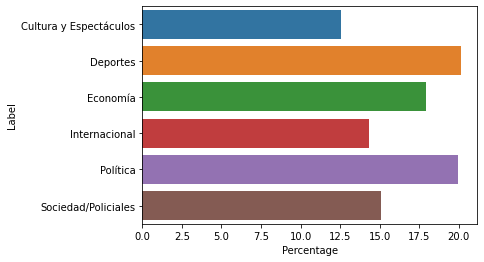

In [8]:
sns.barplot(y="Label", x='Percentage', data=percentages)

The classes are more or less balanced, so we will try to train the models without undersampling, or other techniques. We can check how our models are performing with some metrics like recall, precision, and F1-score.

### Label Codes
We codify the labels.

In [9]:
#We create a dictionary
label_codes={}
num=0
list_of_categories=data.sort_values('Label').Label.unique()
for label in list_of_categories:
    label_codes[label]=num
    num+=1

#Reverse dictionary    
reversed_label_codes = {value : key for (key, value) in label_codes.items()}

# Category mapping
data['Label_code'] = data['Label']
data= data.replace({'Label_code':label_codes})

In [10]:
label_codes

{'Cultura y Espectáculos': 0,
 'Deportes': 1,
 'Economía': 2,
 'Internacional': 3,
 'Política': 4,
 'Sociedad/Policiales': 5}

In [11]:
reversed_label_codes

{0: 'Cultura y Espectáculos',
 1: 'Deportes',
 2: 'Economía',
 3: 'Internacional',
 4: 'Política',
 5: 'Sociedad/Policiales'}

### Train-test split

 We are going to consider only news articles that have a length greater than 5 in the 'Texto_clean_lemmatized_and_stopwords_len' column, and we will keep the 30 percent of the dataset to test. We also keep the column 'Texto clean' in case we need to analyze what happens in the cases that the models predict poorly.

In [12]:
data=data[data['Texto_clean_lemmatized_and_stopwords_len']>5]
X_train, X_test, y_train, y_test = train_test_split(data[['Texto_clean','Texto_clean_lemmatized_and_stopwords']], 
                                                    data['Label_code'], 
                                                    test_size=0.30, 
                                                    random_state=42)

### Text representation


We will use TF-IDF Vectors to represent the text. We will be working only with unigrams (ngram_range = (1,1)). We start with no limit on the maximum number of features (max_features = None) and we will ignore terms that have a document frequency strictly lower than 10 (min_df=10). We can change these parameters, for instance, to avoid overfitting.

In [13]:
# Parameter election - we can change them later
ngram_range = (1,1) #for now we only work with unigrams
min_df = 10  #we ignore terms that have a document frequency strictly lower 10 
max_features=None #for now

#tfidf object
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=False)

In [7]:
features_train = tfidf.fit_transform(X_train['Texto_clean_lemmatized_and_stopwords']).toarray()
features_test = tfidf.transform(X_test['Texto_clean_lemmatized_and_stopwords']).toarray()


In [8]:
features_train.shape

(16728, 8257)

We use chi2 from sklearn.feature_selection, which computes chi-squared stats between each non-negative feature and  class. We compute this to see which unigrams are most correlated with each category (highest values, more correlation)

In [16]:
list_of_categories=data.sort_values('Label').Label.unique()
for label in list_of_categories:
    #we compute the chi2 test between features_train, and labels_train==label_code for each newspaper.
    features_chi2=chi2(features_train,y_train==label_codes[label])
    indices=np.argsort(features_chi2[0])
    features_names = np.array(tfidf.get_feature_names_out())[indices]
    print("Most correlated unigrams in " + label + ":\n. {}".format('\n. '.join(features_names[-10:])))
    print("\n")

Most correlated unigrams in Cultura y Espectáculos:
. festival
. libro
. novela
. netflix
. estrenar
. cantante
. cine
. película
. artista
. actor


Most correlated unigrams in Deportes:
. club
. partido
. fútbol
. gol
. boca
. river
. liga
. equipo
. jugar
. copa


Most correlated unigrams in Economía:
. fmi
. cotización
. subir
. mercado
. cuánto
. inflación
. cotizar
. blue
. precio
. dólar


Most correlated unigrams in Internacional:
. guerra
. eeuu
. militar
. moscú
. reuters
. biden
. kiev
. putin
. ucrania
. rusia


Most correlated unigrams in Política:
. milei
. fmi
. bloque
. gobernador
. cristina
. macri
. kirchner
. diputado
. fernández
. alberto


Most correlated unigrams in Sociedad/Policiales:
. homicidio
. asesinar
. crimen
. acusado
. femicidio
. matar
. joven
. detenido
. víctima
. policía




We observe that the unigrams effectively belong to their category.

We save the files that we will need to train the models.

In [17]:
# X_train
with open('X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# data
with open('data_modified.pickle', 'wb') as output:
    pickle.dump(data, output)

# TF-IDF object
with open('tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)


As features_train and features_test are very large sparse arrays (mostly with zero entries), we will only store values with nonzero entries against their indices, using the method csr_matrix from scipy.sparse.


In [11]:
features_train = csr_matrix(features_train)
features_test=csr_matrix(features_test)

In [12]:
# features_train
with open('features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# features_test
with open('features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)